In [3]:
import os
import cv2
import math
import random
import pickle
import numpy as np
import pandas as pd
from typing import Any
from threading import Thread
from matplotlib import pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

Type Declarations and Helpful Functions

In [4]:
cv2.Image = np.ndarray
cv2.BinaryImage = np.ndarray
cv2.Contour = np.ndarray

# shows an image on ipynb
def imshow(img: np.ndarray) -> None:
    plt.axis('off')
    plt.grid(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def grayscale(img: cv2.Image) -> cv2.Image:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def get_contours(img: cv2.Image, debug: bool = False) -> list[cv2.Contour]:
    gray = grayscale(img)
    blur = cv2.GaussianBlur(gray, (51, 51), 0)
    thresh = cv2.threshold(blur, 100, 255, 0)[1]
    if debug: imshow(thresh) 
    return cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    
def get_random_filename(sheet_data: pd.DataFrame) -> str:
    return sheet_data['filename'][random.randint(0, len(sheet_data)-1)]

def get_optimized_contours(contours: list[cv2.Contour], n: int = 1) -> list[cv2.Contour]:
    """ minimize the area of the rectangle and maximize contour area """
    adjusted_contours = []
    for contour in contours:
        _, _, w, h = cv2.boundingRect(contour)
        adjusted_contours.append([contour, cv2.contourArea(contour)**1.5/(w*h)])
    return [x[0] for x in sorted(adjusted_contours, key=lambda x: x[1], reverse=True)[:n]]

Loads the spreadsheet

In [5]:
SHEET_DATA = pd.read_excel("./data.xlsx")
SHEET_DATA.head()

,filename,treatment,block,row,position,genotype
0,EB00CEE6-848F-4E2A-9A56-C0CD83D55630.jpg,D,1.0,8.0,32.0,BESC-34
1,5AF900F9-D701-4994-95AC-2352420BF18F.jpg,C,1.0,10.0,12.0,"**BESC-417_LM**,core"
2,F7D01515-92CA-4AF5-9BD9-3A4CD99EDF42.jpg,C,2.0,3.0,40.0,BESC-468
3,9117861B-2D2B-4EA8-94B1-D0A862914398.jpg,C,2.0,6.0,54.0,BESC-28_LM
4,D1B282CF-2A10-4458-9E3A-FE08E065A3D6.jpg,C,1.0,24.0,22.0,"**LILD-26-5_LM**,core"


### Segment the leaves from the image

Approach 1: Use large contours and an image mask

dataset/6E764345-3169-4068-AEEE-79A6E225D6D0.jpg


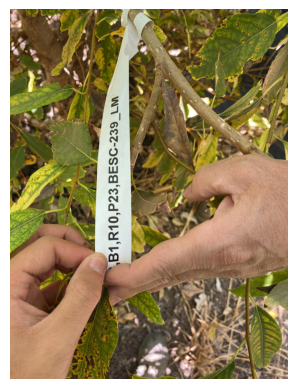

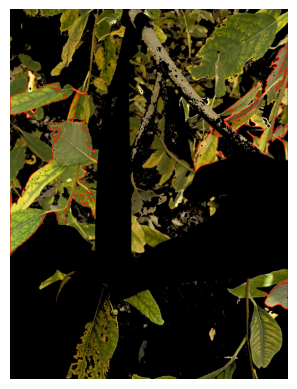

In [6]:
def get_leaves(img: cv2.Image, debug: bool = True) -> Any:
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_img, (20, 70, 60), (80, 255, 255))
    masked = cv2.bitwise_and(img, img, mask=mask)
    biggest_leaves = get_optimized_contours(get_contours(masked, False), n=5)
    masked = cv2.drawContours(masked, biggest_leaves, -1, (0, 0, 255), 5)
    if debug: imshow(masked)

filename = f"dataset/{get_random_filename(SHEET_DATA)}"
# filename = '' # uncomment this line to mess around with a specific filename
print(filename)
img = cv2.imread(filename)
imshow(img)
get_leaves(img, debug=True)

Approach 2: Use Canny Edge detection and image inflation to detect contours

dataset/3586E159-7797-4EB0-B473-C2F3AB58DEAE.jpg


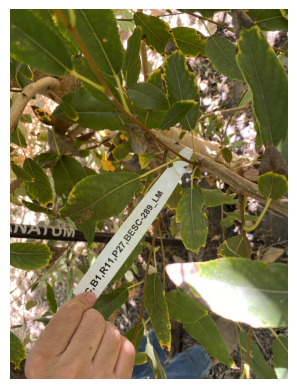

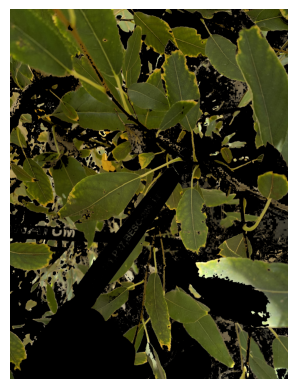

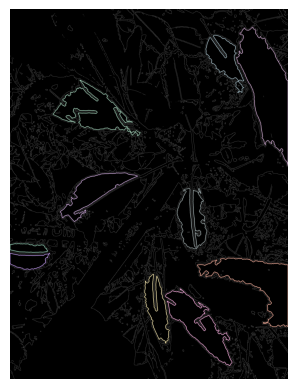

In [7]:
def patchify(img: cv2.BinaryImage, n: int, iters: int) -> Any:
    assert n % 2, "Side length must be odd"
    """ Outputs a square of points around the center (0, 0) with corners removed. """
    new_img = img.copy()
    for _ in range(iters):
        diff = n // 2
        kernel = np.ones((n, n), dtype=np.uint8)
        for y in range(-diff, diff+1):
            for x in range(-diff, diff+1):
                if abs(y) + abs(x) > diff + 1:
                    kernel[y+diff][x+diff] = 0
        new_img = cv2.dilate(new_img, kernel)
    return new_img

def filter_contours(contours: list[cv2.Contour], mask: cv2.BinaryImage) -> list[cv2.Contour]:
    contours = filter(lambda x: len(img) // 10 < max(cv2.boundingRect(x)[-2:]) < len(img) // 2, contours)
    green_colored_contours = []
    for contour in contours: 
        mask_inside_contour = np.zeros_like(mask, np.uint8)
        mask_inside_contour = cv2.drawContours(mask_inside_contour, [contour], -1, 255, -1)
        mean = cv2.mean(mask, mask=mask_inside_contour)
        if mean[0] >= 100:
            green_colored_contours.append(contour)
    contours = get_optimized_contours(green_colored_contours, 10)
    return contours

def draw_contours(contours: list[cv2.Contour], img: cv2.Image, mode: str = "random") -> cv2.Image:
    """ Draw contours onto an image with random colors """
    draw_img = img.copy()
    for contour in contours:
        match mode:
            case "random":
                color = tuple(random.randint(150, 255) for _ in range(3))
            case "red": 
                color = (0, 0, 255)
            case "blue":
                color = (255, 0, 0)
            case "green":
                color = (0, 255, 0)
            case _:
                raise Exception("Invalid color mode.")
        draw_img = cv2.drawContours(draw_img, [contour], -1, color, 5)
    return draw_img

def get_leaf_contours(img: cv2.Image, debug: bool = False) -> list[cv2.Contour]:

    # generate a mask for the image (colors we are interested in)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_img, (20, 50, 50), (80, 255, 255))
    masked = cv2.bitwise_and(img, img, mask=mask)
    if debug: imshow(masked)

    # find the edges using the Canny algorithm
    img_blur = cv2.GaussianBlur(masked, (23, 23), sigmaX=0, sigmaY=0) 
    edges = cv2.Canny(img_blur, threshold1=20, threshold2=40)
    dilated = cv2.bitwise_not(patchify(edges, 13, iters=2))

    # find the contours in the resulting image to determine which ones are leaves
    contours = filter_contours(cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0], mask)

    # display found leaves
    if debug:
        drawn_contours = draw_contours(contours, cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR))
        imshow(drawn_contours)

    return contours

filename = f"dataset/{get_random_filename(SHEET_DATA)}"
filename = 'dataset/3586E159-7797-4EB0-B473-C2F3AB58DEAE.jpg' # uncomment this line to mess around with a specific filename
print(filename)
img = cv2.imread(filename)
imshow(img)
_ = get_leaf_contours(img, debug=True)

#### Train a simple ML model to detect leaves

Generating data (subjective, selected by me)

In [12]:
def get_features(contour: cv2.Contour) -> dict[str, float]:

    # get contour moments
    moments = cv2.HuMoments(cv2.moments(contour))
    adjusted_moments = map(lambda x: -math.copysign(1.0, x) * math.log10(abs(x)), [*moments])
    moment_dict = {f'h{i}': m for i, m in enumerate(adjusted_moments)}

    area = cv2.contourArea(contour)
    x, y, w, h = cv2.boundingRect(contour)

    # the idea here is that ratios are more important than the values themselevs
    # get ratio of area to bounding rect, perimeter, and bounding hull
    area_rect_ratio = area / (w * h)
    area_peri_ratio = area / cv2.arcLength(contour, True) ** 2    # might make it too sensitive :O
    convex_area_ratio = area / cv2.contourArea(cv2.convexHull(contour))

    # ratio of area covered by fit ellipse to contour
    el_mask, cnt_mask = [np.zeros((y+h*3, x+w*3)) for _ in range(2)]
    ellipse = cv2.fitEllipse(contour)
    ellipse_area = float(np.prod(ellipse[1])) * math.pi / 4
    el_mask = cv2.ellipse(el_mask, ellipse, 100, thickness=cv2.FILLED)
    cnt_mask = cv2.drawContours(cnt_mask, [contour], -1, 100, cv2.FILLED)
    total_mask = cv2.threshold((el_mask + cnt_mask).astype(np.uint8), 150, 255, 0)[1]
    merged_contours = cv2.findContours(total_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    total_merged_area = sum(map(cv2.contourArea, merged_contours))

    # ratio of area (in contour and ellipse) to interesct with bounding ellipse
    try:
        area_intersect_ratio = area / total_merged_area
        area_ellipse_intersect_ratio = ellipse_area / total_merged_area
    except ZeroDivisionError:
        area_intersect_ratio = area_ellipse_intersect_ratio = 100000  # big number D:

    # return extracted features
    return {
        'area_peri': area_peri_ratio,
        'area_rect': area_rect_ratio,
        'area_convex': convex_area_ratio,
        'area_elli_inter': area_intersect_ratio,
        'ellipse_elli_inter': area_ellipse_intersect_ratio
    } | moment_dict    

In [ ]:
IMAGE_COUNT = 20

class FeatureThread(Thread):
    def __init__(self, contour):
        Thread.__init__(self)
        self.contour = contour
        self.features = None
    def run(self):
        self.features = get_features(self.contour)

def generate_training_data():
    data = []
    images = [f"dataset/{get_random_filename(SHEET_DATA)}" for _ in range(IMAGE_COUNT)]
    try:
        for filename in images:

            # get the image and the leaf contours
            img = cv2.imread(filename)
            contours = get_leaf_contours(img)

            # go through each leaf
            for contour in contours:

                # start a thread for feature extraction
                thread = FeatureThread(contour)
                thread.start()

                # generate mask of only the leaf being shown
                mask = cv2.drawContours(np.zeros_like(img), [contour], -1, 255, cv2.FILLED)
                masked_img = cv2.bitwise_and(img, img, mask=grayscale(mask))
                imshow(masked_img)
                
                # wait for thread to run during input, join thread, and take data
                is_leaf = input("Is this image leaf-shaped?")
                thread.join()
                data.append(thread.features | {'is_leaf': is_leaf})
                clear_output()
    
    # store data regardless of exit scenario
    finally:
        df = pd.DataFrame(data)
        print(df.head())
        if "leaf_identification" not in os.listdir():
            os.mkdir('leaf_identification')
        df.to_csv('leaf_identification/data.csv', index=False)
        
generate_training_data()

Train the model

In [51]:
# process the data 
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df_leaf = df[df['is_leaf'] == 'y']
    df_no_leaf = df[df['is_leaf'] == 'n']
    n = len(df_no_leaf) - len(df_leaf)
    drop_indeces = np.random.choice(df_no_leaf.index, n, replace=False)
    return pd.concat([df_no_leaf.drop(drop_indeces), df_leaf], ignore_index=True)

# get training and testing data
df = preprocess(pd.read_csv("leaf_identification/data.csv"))
y_col = [*map(lambda x: x.lower() == 'y', df.pop('is_leaf'))]
X_train, X_test, y_train, y_test = train_test_split(df, y_col, test_size=0.3)

# adjust the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# train the model and save
model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train, y_train)
with open("leaf_identification/model.pkl", "wb") as f:
    pickle.dump(model, f)
with open("leaf_identification/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):2%}")

Accuracy: 69.230769%


In [52]:
print(*zip(y_test, y_pred), sep="\n")

(True, True)
(True, True)
(True, False)
(True, False)
(True, True)
(True, False)
(True, False)
(True, False)
(False, False)
(False, False)
(True, False)
(True, True)
(True, True)
(True, True)
(False, False)
(False, False)
(False, False)
(True, True)
(False, False)
(True, False)
(True, True)
(False, False)
(False, False)
(False, False)
(True, True)
(True, False)


Load the model and predict on leaf contours :)

dataset/C294E84A-5A83-4CD2-977C-3C8AD5F2E59D.jpg


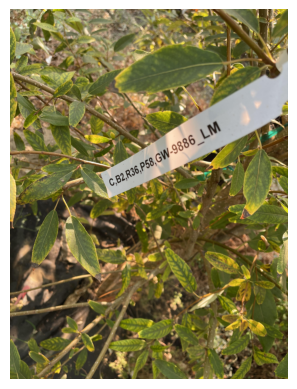

/tmp/ipykernel_2821/900165369.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  adjusted_moments = map(lambda x: -math.copysign(1.0, x) * math.log10(abs(x)), [*moments])


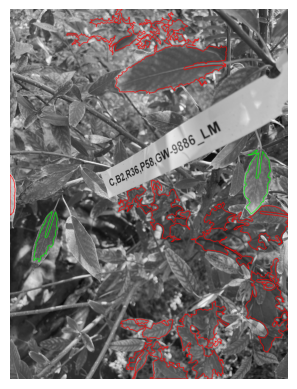

In [15]:
def load_models() -> tuple[RandomForestClassifier, StandardScaler]:
    with open("leaf_identification/model.pkl", 'rb') as f:
        model = pickle.load(f)
    with open("leaf_identification/scaler.pkl", 'rb') as f:
        scaler = pickle.load(f)
    return (model, scaler)

def find_real_leaf_contours(img: cv2.Image, model: RandomForestClassifier, scaler: StandardScaler) -> list[cv2.Contour]:
    contours = get_leaf_contours(img)
    features = scaler.transform(pd.DataFrame([*map(get_features, contours)]))
    predictions = model.predict(features)
    real_contours, bad_contours = [], []
    for cntr, pred in zip(contours, predictions):
        if pred: real_contours.append(cntr)
        else: bad_contours.append(cntr)
    return real_contours, bad_contours

# loads the ML models
MODEL, SCALER = load_models()

filename = f"dataset/{get_random_filename(SHEET_DATA)}"
# filename = '' # uncomment this for specific files
print(filename)
img = cv2.imread(filename)
imshow(img)
contours, bad_contours = find_real_leaf_contours(img, MODEL, SCALER)
drawn_img = draw_contours(contours, cv2.cvtColor(grayscale(img), cv2.COLOR_GRAY2BGR), mode="green")
drawn_img = draw_contours(bad_contours, drawn_img, mode="red")
imshow(drawn_img)